In [973]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re
reddit_ml = pd.read_csv('reddit_ml.csv')
reddit_ml = reddit_ml.iloc[:,1:8]
reddit_ml = reddit_ml.astype({'title':str,'date':str,
                              'genre':str,'reply':int,
                              'support':str})

for i in range(reddit_ml.shape[0]):
    # clean the genre column, which is not correct in the raw file
    if (reddit_ml["title"][i][:3] == '[R]'):
        reddit_ml.loc[:,"genre"][i] = 'Research'
    elif (reddit_ml["title"][i][:3] == '[D]'):
        reddit_ml.loc[:,"genre"][i] = 'Discussion'
    elif (reddit_ml["title"][i][:3] == '[N]'):
        reddit_ml.loc[:,"genre"][i] = 'News'
    elif (reddit_ml["title"][i][:3] == '[P]'):
        reddit_ml.loc[:,"genre"][i] = 'Project'
    else:
        reddit_ml.loc[:,"genre"][i] = 'General'
    # clean the support column which contains something like 1.1k and transfer to numbers    
    if (reddit_ml.loc[i,'support'][-1] == 'k'):
        reddit_ml.loc[i,'support'] = float(reddit_ml.loc[i,'support'][:-1]) * 1000
    else:
        reddit_ml.loc[i,'support'] = float(reddit_ml.loc[i,'support'])
    
    # clean the date column and set them with same unit of months
    if ('month' in reddit_ml.loc[i,'date']):
        reddit_ml.loc[i,'date'] = float(re.findall('[1-9]+', reddit_ml.loc[i,'date'])[0])
    elif ('year' in reddit_ml.loc[i,'date']):
        reddit_ml.loc[i,'date'] = float(re.findall('[1-9]+', reddit_ml.loc[i,'date'])[0]) * 12
    else:
        reddit_ml.loc[i,'date'] = float(re.findall('[1-9]+', reddit_ml.loc[i,'date'])[0])/30

# reset the column names and types
reddit_ml = reddit_ml.rename(columns={'date': 'date_months_ago',
                 'reply': 'num_of_reply',
                 'support': 'num_of_support'})

reddit_ml = reddit_ml.astype({'num_of_reply':int,
                              'num_of_support':int})   

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to 

In [1547]:
#set the uncommon_words which will not be counted 
uncommon_words = stopwords.words('english') + ['[',']','d','r','n','p',"'s",'``',"''"]

# replace some important info in the title
reddit_ml['title'] = reddit_ml['title'].str.lower()
reddit_ml.title = reddit_ml.title.str.replace('machine learning',"machine-learning")
reddit_ml.title = reddit_ml.title.str.replace('ml',"machine-learning")
reddit_ml.title = reddit_ml.title.str.replace('deep learning',"deep-learning")
reddit_ml.title = reddit_ml.title.str.replace('a.i',"ai")
reddit_ml.title = reddit_ml.title.str.replace('/', ' ')

# function to count the words, support number, reply numbers
def count(raw_df):
    word_count = {}
    sup_count = {}
    rep_count = {}
    for i in range(raw_df.shape[0]):
        word_title = word_tokenize(raw_df['title'][i])
        for word in word_title:
            if ((word in uncommon_words) | (len(word) == 1)) == False:
                if word in word_count:
                    word_count[word] += 1
                    sup_count[word] += raw_df.num_of_support[i]
                    rep_count[word] += raw_df.num_of_reply[i]
                else:
                    word_count[word] = 1
                    sup_count[word] = raw_df.num_of_support[i]
                    rep_count[word] = raw_df.num_of_reply[i]

    word_count_df = pd.DataFrame(list(word_count.items()), columns = ['words','counts'])
    sup_count_df = pd.DataFrame(list(sup_count.items()), columns = ['words','sup_counts'])
    rep_count_df = pd.DataFrame(list(rep_count.items()), columns = ['words','rep_counts'])
    count_df = merge_multi('words', word_count_df,sup_count_df,rep_count_df)
    return count_df
reddit_ml_count = count(reddit_ml)
reddit_ml_count.loc[:,'ave_sup']  = reddit_ml_count.loc[:,'sup_counts']//reddit_ml_count.loc[:, 'counts']
reddit_ml_count.loc[:,'ave_rep'] = reddit_ml_count.loc[:,'rep_counts']//reddit_ml_count.loc[:, 'counts']
reddit_ml_count1=reddit_ml_count.sort_values('ave_sup', ascending = False).drop([1036,308,673,92,993,19,41,2940, 2553, 2934,2919,720,2093])

# fucntion to mergy multiple dataframes by x
def merge_multi(x, *args):
    df = args[0]
    for arg in args[1:]:
        df = pd.merge(df, arg,how='outer',on = x)
    return df



In [1030]:
# filter by genre and creat new datafames
d_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Discussion'].reset_index()
r_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Research'].reset_index()
n_genre = reddit_ml[reddit_ml.loc[:,'genre']=='News'].reset_index()
p_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Project'].reset_index()
g_genre = reddit_ml[reddit_ml.loc[:,'genre']=='General'].reset_index()


discussion_count = count(d_genre).sort_values('counts', ascending = False)
research_count = count(r_genre).sort_values('counts', ascending = False)
news_count = count(n_genre).sort_values('counts', ascending = False)
project_count = count(p_genre).sort_values('counts', ascending = False)
general_count = count(g_genre).sort_values('counts', ascending = False)

# rename the columns in case of merging comfusion
discussion_count.rename(columns = {'counts':'d_counts',
                        'sup_counts':'dsup_counts',
                        'rep_counts':'drep_counts'},
                       inplace = True)

research_count.rename(columns = {'counts':'r_counts',
                        'sup_counts':'rsup_counts',
                        'rep_counts':'rrep_counts'},
                         inplace = True)

news_count.rename(columns = {'counts':'n_counts',
                        'sup_counts':'nsup_counts',
                        'rep_counts':'nrep_counts'},
                     inplace = True)

project_count.rename(columns = {'counts':'p_counts',
                        'sup_counts':'psup_counts',
                        'rep_counts':'prep_counts'},
                        inplace = True)

general_count.rename(columns = {'counts':'g_counts',
                        'sup_counts':'gsup_counts',
                        'rep_counts':'grep_counts'},
                        inplace = True)

# mergy these columns and drop some rows contain uncommon words
count_by_genre = merge_multi('words', 
                             discussion_count,research_count,news_count,
                             project_count, general_count).fillna(0)



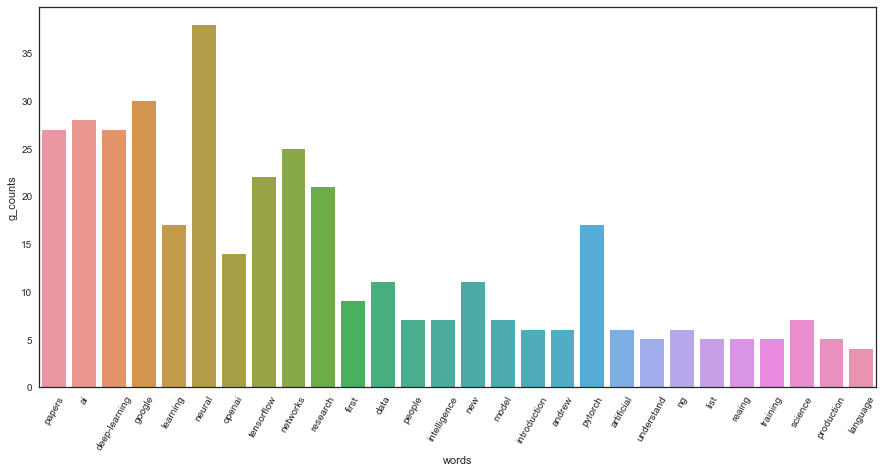

In [1863]:
bar_genre_df = count_by_genre.sort_values('d_counts', ascending = False).drop([0,23,25,27,28,29,30,40,43,58,61,64],axis = 0).head(30)
d_count_plots = sns.barplot(x= 'words', y='d_counts', data = bar_genre_df.iloc[:-2,:])
d_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
d_count_plots = sns.set(style = 'white')

plt.savefig('d_count_plots.pdf', dpi=400)

r_count_plots = sns.barplot(x= 'words', y='r_counts', data = bar_genre_df.iloc[:-2,:])
r_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
r_count_plots = sns.set(style='white')
plt.savefig('r_count_plots.pdf', dpi=400)

n_count_plots = sns.barplot(x= 'words', y='n_counts', data = bar_genre_df.iloc[:-2,:])
n_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
n_count_plots = sns.set(style='white')
plt.savefig('n_count_plots.pdf', dpi=400)


p_count_plots = sns.barplot(x= 'words', y='p_counts', data = bar_genre_df.iloc[:-2,:])
p_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
p_count_plots = sns.set(style='white')
plt.savefig('p_count_plots.pdf', dpi=400)

g_count_plots = sns.barplot(x= 'words', y='g_counts', data = bar_genre_df.iloc[:-2,:])
g_count_plots.set_xticklabels(labels = bar_genre_df['words'],rotation=60)
g_count_plots = sns.set(style='white')
plt.savefig('g_count_plots.pdf', dpi=400)


In [ ]:
#!!! filter by genre and creat new datafames
d_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Discussion'].reset_index()
r_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Research'].reset_index()
n_genre = reddit_ml[reddit_ml.loc[:,'genre']=='News'].reset_index()
p_genre = reddit_ml[reddit_ml.loc[:,'genre']=='Project'].reset_index()
g_genre = reddit_ml[reddit_ml.loc[:,'genre']=='General'].reset_index()


discussion_count = count(d_genre).sort_values('counts', ascending = False)
research_count = count(r_genre).sort_values('counts', ascending = False)
news_count = count(n_genre).sort_values('counts', ascending = False)
project_count = count(p_genre).sort_values('counts', ascending = False)
general_count = count(g_genre).sort_values('counts', ascending = False)

# rename the columns in case of merging comfusion
discussion_count.rename(columns = {'counts':'d_counts',
                        'sup_counts':'dsup_counts',
                        'rep_counts':'drep_counts'},
                       inplace = True)

research_count.rename(columns = {'counts':'r_counts',
                        'sup_counts':'rsup_counts',
                        'rep_counts':'rrep_counts'},
                         inplace = True)

news_count.rename(columns = {'counts':'n_counts',
                        'sup_counts':'nsup_counts',
                        'rep_counts':'nrep_counts'},
                     inplace = True)

project_count.rename(columns = {'counts':'p_counts',
                        'sup_counts':'psup_counts',
                        'rep_counts':'prep_counts'},
                        inplace = True)

general_count.rename(columns = {'counts':'g_counts',
                        'sup_counts':'gsup_counts',
                        'rep_counts':'grep_counts'},
                        inplace = True)

# mergy these columns and drop some rows contain uncommon words
count_by_genre = merge_multi('words', 
                             discussion_count,research_count,news_count,
                             project_count, general_count).fillna(0)

count_by_genre.drop([11,12,13,14,16,18,26,32,33], axis = 0, inplace=True)

ratio_by_genre = pd.DataFrame()
names = count_by_genre.columns.values
for i in range(1,count_by_genre.shape[1]):
    ratio_by_genre.loc[:,names[i]] = count_by_genre.iloc[:,i]/count_by_genre.agg('sum')[i] * 100

    
sort_by_d_counts = count_by_genre.sort_values('d_counts', ascending = False).reset_index()
sort_by_d_counts.drop('index',axis=1, inplace = True)         
sort_by_r_counts = count_by_genre.sort_values('r_counts', ascending = False).reset_index()
sort_by_r_counts.drop('index',axis=1, inplace = True) 
sort_by_n_counts = count_by_genre.sort_values('n_counts', ascending = False).reset_index()
sort_by_n_counts.drop('index',axis=1, inplace = True) 
sort_by_g_counts = count_by_genre.sort_values('g_counts', ascending = False).reset_index()
sort_by_g_counts.drop('index',axis=1, inplace = True) 
sort_by_p_counts = count_by_genre.sort_values('p_counts', ascending = False).reset_index()
sort_by_p_counts.drop('index',axis=1, inplace = True) 

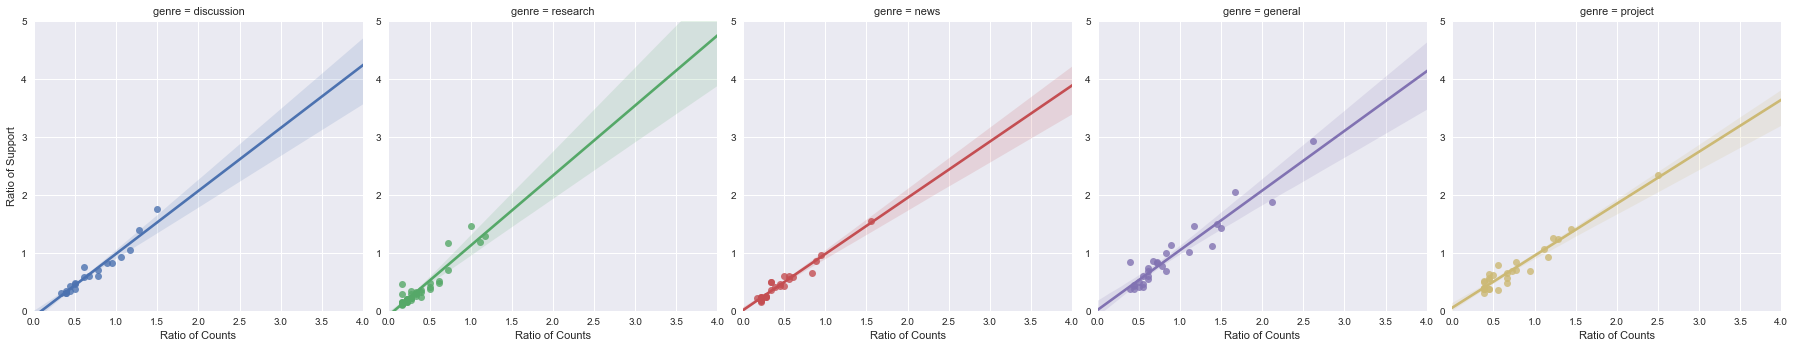

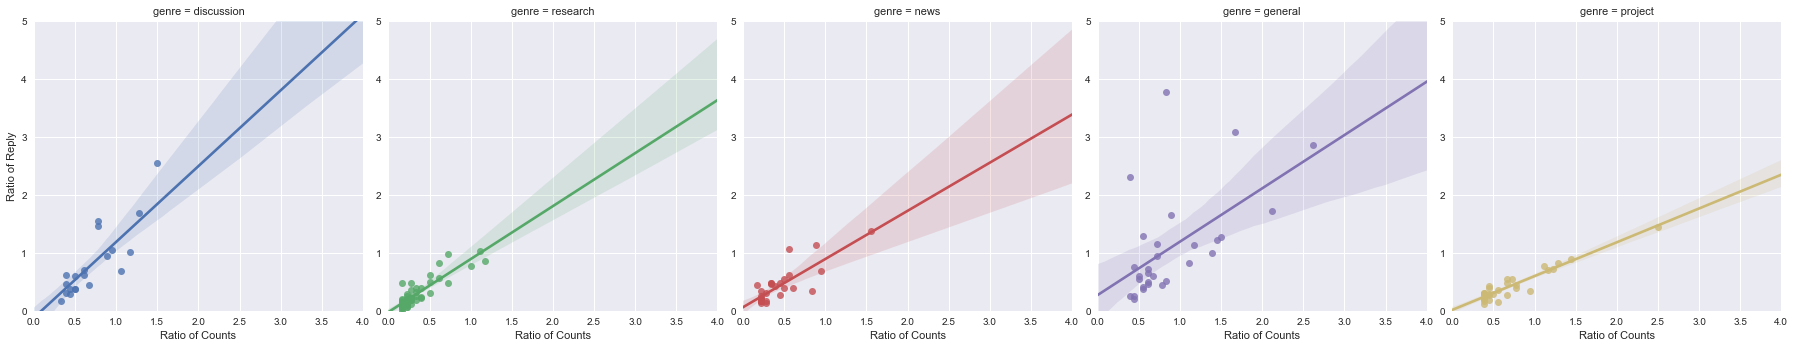

In [1815]:
#combine all counts and sup/rep counts and calculate the ratio
discussion_count1 = count(d_genre).sort_values('counts', ascending = False)

research_count1 = count(r_genre).sort_values('counts', ascending = False)
news_count1 = count(n_genre).sort_values('counts', ascending = False)
project_count1 = count(p_genre).sort_values('counts', ascending = False)
general_count1 = count(g_genre).sort_values('counts', ascending = False)
discussion_count1.loc[:,'genre'] = 'discussion'
research_count1.loc[:,'genre'] = 'research'
news_count1.loc[:,'genre'] = 'news'
project_count1.loc[:,'genre'] = 'project'
general_count1.loc[:,'genre'] = 'general'

new_df = pd.DataFrame()
new_df = discussion_count1.head(30).append(research_count1.head(50))
new_df = new_df.append(news_count1.head(30))
new_df = new_df.append(general_count1.head(30))
new_df = new_df.append(project_count1.head(30))
new_df.loc[:,'ave_sup'] = new_df.loc[:,'sup_counts']/new_df.loc[:, 'counts']
new_df.loc[:,'ave_rep'] = new_df.loc[:,'rep_counts']/new_df.loc[:, 'counts']
new_ratio = pd.DataFrame() 
for i in range(1,4):
    new_ratio.loc[:,names[i]] = new_df.iloc[:,i]/new_df.agg('sum')[i] * 100
new_ratio.loc[:,'genre'] = new_df.loc[:,'genre']
new_ratio.loc[:,'words'] = new_df.loc[:,'words']
new_ratio.head(20)
new_ratio = new_ratio.drop([44,183,262,293,458,92,222,331,294,173,226,19,614], axis = 0)

# plot the counts and sup/rep counts
sup_fig = sns.lmplot("d_counts", "dsup_counts", new_ratio,hue = 'genre',col='genre')
rep_fig = sns.lmplot("d_counts", "drep_counts", new_ratio,hue = 'genre',col='genre')
sup_fig1 = sup_fig.set(xlim = [0,1.5], ylim = [0,2.2])
rep_fig1 = rep_fig.set(xlim = [0,1.5], ylim = [0,2.2])
sup_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig1.savefig("sup_fig1", format = 'pdf', dpi = 500)
rep_fig1.savefig("rep_fig1", format = 'pdf', dpi = 500)
sup_fig.set(xlim = [0,4], ylim = [0,5])
rep_fig.set(xlim = [0,4], ylim = [0,5])
sup_fig.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig.savefig("sup_fig", format = 'pdf', dpi = 500)
rep_fig.savefig("rep_fig", format = 'pdf', dpi = 500)

In [1847]:
new_df1 = pd.DataFrame()
new_df1 = discussion_count1.iloc[1:10,].append(research_count1.iloc[1:10,])
new_df1 = new_df1.append(news_count1.iloc[1:10,])
new_df1 = new_df1.append(general_count1.iloc[1:10,])
new_df1 = new_df1.append(project_count1.iloc[1:10,])
new_df1.loc[:,'ave_sup'] = new_df1.loc[:,'sup_counts']//new_df1.loc[:, 'counts']
new_df1.loc[:,'ave_rep'] = new_df1.loc[:,'rep_counts']//new_df1.loc[:, 'counts']
new_df1.drop([262,19,309,175,36,614,293], inplace = True)

In [ ]:
print(new_df.head(10))
tips = sns.load_dataset("tips")
tips.head()
g = sns.FacetGrid(tips, col="day",aspect=.5)
g.map(sns.barplot, "sex", "total_bill")

In [1666]:
new_df1 = pd.DataFrame()
new_df1 = discussion_count1.head(30).append(research_count1.head(30))
new_df1 = new_df.append(news_count1.head(30))
new_df1 = new_df.append(general_count1.head(30))
new_df1 = new_df.append(project_count1.head(30))
#sns.barplot(x=new_df1['words'], y=new_df1['counts'], palette="BuPu")

In [1511]:
new_df.loc[:,'ave_sup'] = new_df.loc[:,'sup_counts']//new_df.loc[:, 'counts']
new_df.loc[:,'ave_rep'] = new_df.loc[:,'rep_counts']//new_df.loc[:, 'counts']
new_df.sort_values('ave_sup', ascending =False)



In [1867]:
import plotly
import plotly.graph_objects as go
from IPython.display import Image
import plotly.io as pio

plotly.offline.init_notebook_mode(connected=True)
from plotly.graph_objs import Figure, Histogram, Layout
#ave_sup_fig = sns.lmplot("counts", "ave_sup", new_df,hue = 'genre',col='genre')
#ave_rep_fig = sns.lmplot("counts", "ave_rep", new_df,hue = 'genre',col='genre')
ave_sup_fig = go.Figure(data=go.Scatter(x=reddit_ml_count1['counts'],
                                y=reddit_ml_count1['ave_sup'],
                                mode='markers',
                                marker = dict(color=reddit_ml_count1['ave_sup'],
                                              colorscale='Delta',
                                             showscale=True),    
                                text=reddit_ml_count1['words']))
ave_sup_fig.update_layout(title=go.layout.Title(text="Average Support Plot"),
                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Support")))


"""
ave_rep_fig = go.Figure(data=go.Scatter(x=reddit_ml_count1['counts'],
                                y=reddit_ml_count1['ave_rep'],
                                mode='markers',
                                marker = dict(color=reddit_ml_count1['ave_rep'],
                                              colorscale='Phase',
                                             showscale=True),
                                text=reddit_ml_count1['words']))"""
"""ave_rep_fig.update_layout(title=go.layout.Title(text="Average Reply Plot"),
                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Reply")))"""


'ave_rep_fig.update_layout(title=go.layout.Title(text="Average Reply Plot"),\n                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),\n                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Reply")))'

In [1868]:
ave_sup_fig = go.Figure(data=go.Scatter(x=reddit_ml_count1['counts'],
                                y=reddit_ml_count1['ave_sup'],
                                mode='markers',
                                marker = dict(color=reddit_ml_count1['ave_sup'],
                                              colorscale='Delta',
                                             showscale=True),    
                                text=reddit_ml_count1['words']))
ave_sup_fig.update_layout(title=go.layout.Title(text="Average Support Plot"),
                  xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Words Counts")),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Average Support")))

In [1573]:
plotly.io.orca.config.executable = '/Applications/anaconda3/pkgs/plotly-orca-1.2.1-1'
plotly.io.orca.config.save()

In [1856]:
new_ratio.sample(5)

,d_counts,dsup_counts,drep_counts,genre,words
407,0.389538,0.396788,0.311902,project,project
175,0.667780,0.484482,0.272381,project,networks
86,1.446856,1.497726,1.220906,general,ai
368,0.556483,0.593279,1.292473,general,alphago
213,0.166945,0.121077,0.079044,research,notes


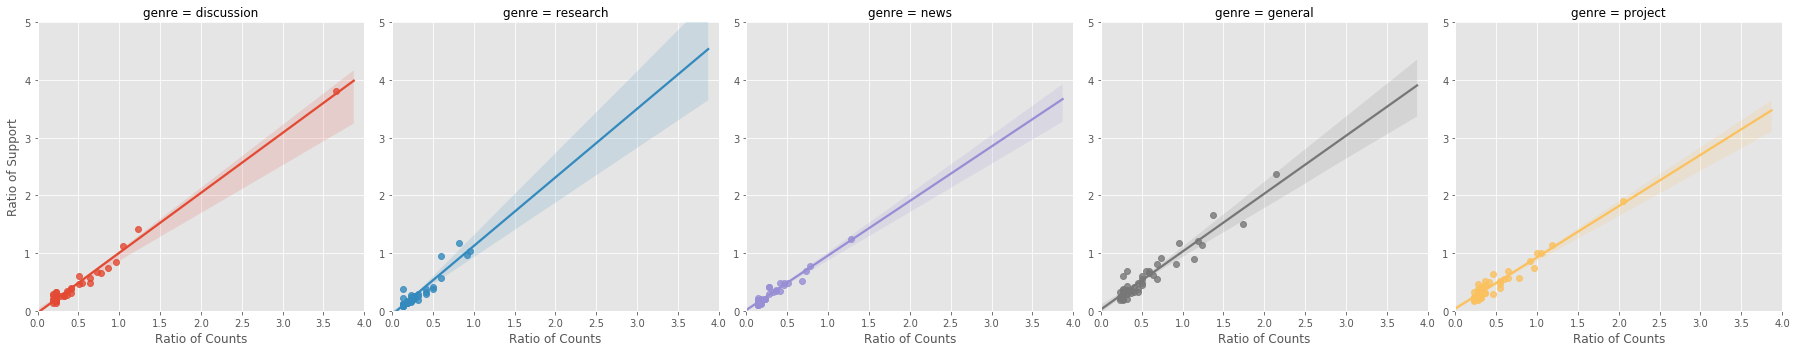

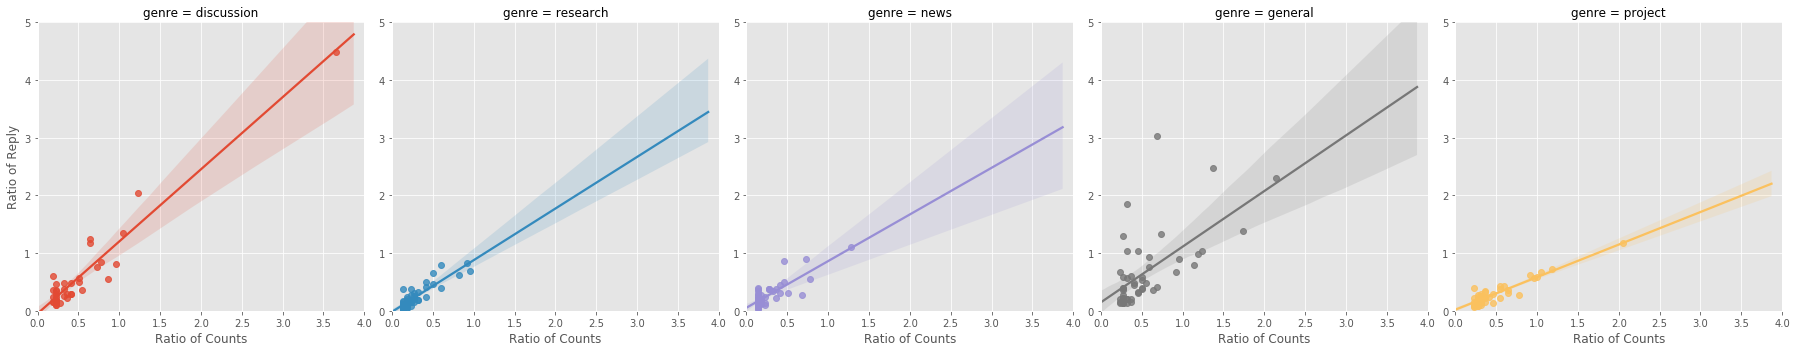

In [1478]:
sup_fig = sns.lmplot("d_counts", "dsup_counts", new_ratio,hue = 'genre',col='genre')
rep_fig = sns.lmplot("d_counts", "drep_counts", new_ratio,hue = 'genre',col='genre')
sup_fig1 = sup_fig.set(xlim = [0,1.5], ylim = [0,2.2])
rep_fig1 = rep_fig.set(xlim = [0,1.5], ylim = [0,2.2])
sup_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig1.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig1.savefig("sup_fig1", format = 'pdf', dpi = 500)
rep_fig1.savefig("rep_fig1", format = 'pdf', dpi = 500)
sup_fig.set(xlim = [0,4], ylim = [0,5])
rep_fig.set(xlim = [0,4], ylim = [0,5])
sup_fig.set_axis_labels('Ratio of Counts', 'Ratio of Support')
rep_fig.set_axis_labels('Ratio of Counts', 'Ratio of Reply')
sup_fig.savefig("sup_fig", format = 'pdf', dpi = 500)
rep_fig.savefig("rep_fig", format = 'pdf', dpi = 500)

In [1451]:
import plotly.express as px
fig = px.scatter(new_ratio, x="d_counts", y="dsup_counts", color = 'words',
                 hover_data=['words'],facet_col = 'genre', trendline="ols",
                render_mode="webgl")
fig.write_image("fig1.pdf")

In [1629]:
new_ratio.columns

Index(['Counts Ratio_%', 'Support Ratio_%', 'Report Ratio_%', 'genre',
       'words'],
      dtype='object')

In [1630]:
new_ratio.rename(columns = {'d_counts':'Counts Ratio_%','dsup_counts':'Support Ratio_%',
                  'Report Ratio_%':'Reply Ratio_%'}, inplace = True)


In [1624]:
import plotly.express as px
sup_ratio = px.scatter(new_ratio,x = "Counts Ratio_%", y="Support Ratio_%", 
                       color="genre", facet_col="genre", trendline = "ols",
                      hover_name="words")

plotly.offline.iplot(sup_ratio, show_link= True, image_width=800, image_height=600)

In [ ]:
#draw word figures
from IPython.display import Image
import numpy as np
from PIL import Image
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import ImageColorGenerator

#draw news topics
mask = np.array(Image.open("spain-flag.jpg"))
news_words = WordCloud(background_color="white", max_font_size=400,max_words=200, mask = mask,stopwords=uncommon_words)
news_words.generate(' '.join(sort_by_n_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 200)
plt.imshow(news_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("News Topic")
plt.savefig("News_Topic_span_50", format="png")
plt.show()

# project words figure
mask = np.array(Image.open("baby.jpg"))
project_words = WordCloud(background_color="white", max_font_size=400,max_words=200, mask = mask,stopwords=uncommon_words)
project_words.generate(' '.join(sort_by_p_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(project_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Project Topic")
plt.savefig("Project_Topic_ai_50", format="png")
plt.show()

# discussion topic figure
mask = np.array(Image.open("brain.jpg"))
discussion_words = WordCloud(background_color="white",max_font_size=400, max_words=200, mask = mask,stopwords=uncommon_words)
discussion_words.generate(' '.join(sort_by_d_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(discussion_words, interpolation="bilinear")
plt.axis("off")
plt.title("Discussion Topic")
plt.savefig("Discussion_Topic_ai_50", format="png")
plt.show()

# general topic figure
mask = np.array(Image.open("T-shirt.jpg"))
general_words = WordCloud(background_color="white", max_font_size=400, max_words=200, mask = mask,stopwords=uncommon_words)
general_words.generate(' '.join(sort_by_g_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(general_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("General Topic")
plt.savefig("General_Topic_50", format="png")
plt.show()

#draw research figure
mask = np.array(Image.open("pipk.jpeg"))
research_words = WordCloud(background_color="white", max_font_size=400,max_words=400, mask = mask,stopwords=uncommon_words)
research_words.generate(' '.join(sort_by_r_counts.loc[:50,'words']))  
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7), dpi = 300)
plt.imshow(research_words.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Research Topic")
plt.savefig("Research_Topic_50", format="png")
plt.show()
